In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pyro
import pyro.distributions as dist
import scipy as sp
import scipy.stats
import time
import torch
import yaml
try:
    from yaml import CLoader as Loader
except ImportError:
    from yaml import Loader

In [2]:
# These scenes include uniformly randomly distributed nonpenetrating
# object arrangements
DATA_FILE = "data/20181127_uniform_feasible_1_box_1000/20181207_uniform_feasible_1_box_1000.yaml"
# These loaded scenes include squares on the left half of the scene, and
# long rectangles on the right half of the scene. All objects
# tend to lie along cardinal directions (theta = 0, pi/2, pi, ...)
#DATA_FILE = "data/20180709_sorted_grid_10000.yaml"

with open(DATA_FILE, "r") as f:
    environments = yaml.load(f, Loader=Loader)
    N_ENVIRONMENTS = len(environments.keys())
    print("Loaded %d environments from file %s" % (N_ENVIRONMENTS, DATA_FILE))
environments = [environments[key] for key in environments.keys()]

Loaded 1000 environments from file data/20181127_uniform_feasible_1_box_1000/20181207_uniform_feasible_1_box_1000.yaml


In [3]:
# Utilities
import generate_planar_scene_arrangements as psa_utils

def draw_rbt(ax, rbt, q):
    psa_utils.draw_board_state(ax, rbt, q)
    
    patch = patches.Rectangle([0., 0.], 1., 1., fill=True, color=[0., 1., 0.], 
                              linestyle='solid', linewidth=2, alpha=0.3)
    ax.add_patch(patch)
    
def draw_environment(environment, ax):
    rbt, q = psa_utils.build_rbt_from_summary(environment)
    draw_rbt(ax, rbt, q)

. Loss:  97.5029834231
. . . . tensor([[2.2732e-02, 9.8824e-01, 1.1437e-04, 4.0231e-03, 1.9525e-03, 2.6952e-01,
         1.8239e-01, 4.5463e-01, 3.9677e-01, 7.1678e-03, 5.5765e-03, 1.7465e+00,
         8.9934e-01, 9.2311e-01, 2.7388e-02, 8.9218e-03, 5.5491e-03, 3.9019e-01,
         2.5377e-01, 3.1592e-01, 8.0074e-01, 1.2881e-02, 4.1698e-03, 4.7439e+00,
         3.9780e-01, 6.0992e-01, 8.5044e-02, 2.0112e-03, 2.1308e-03, 2.7058e+00,
         4.5754e-01, 6.7841e-01, 9.5789e-01, 8.6922e-03, 9.3364e-03, 5.7295e+00,
         8.2725e-01, 7.2422e-01, 1.8288e-02, 1.0038e-02, 1.3127e-02, 3.5241e+00,
         6.6823e-01, 4.7835e-01, 1.0323e-01, 5.9363e-03, 1.2073e-02, 5.4989e+00,
         4.9029e-01, 3.3108e-02, 1.9367e-02, 9.0304e-03, 2.8152e-03, 4.9978e-01,
         4.6925e-01, 4.6655e-01, 5.7412e-01, 1.9519e-03, 7.8394e-03, 2.0007e+00]],
       dtype=torch.float64, grad_fn=<TBackward>)


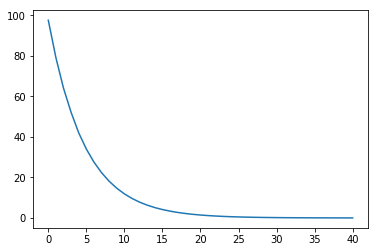

In [4]:
# Try out gradient descent through the projection operator
import differentiable_nlp as diff_nlp
from copy import deepcopy

device = torch.device('cpu')
env_i = environments[13]

rbt, qf = psa_utils.build_rbt_from_summary(env_i)
nq = rbt.get_num_positions()
#q = torch.tensor(qf.reshape(nq, 1), requires_grad=True)
np.random.seed(1)
q_start = np.random.random([nq, 1])
q = torch.tensor(q_start, requires_grad=True, dtype=torch.double)
q_target = torch.tensor(qf).view(nq, 1)

learning_rate = 0.05
constraints = [diff_nlp.object_origins_within_bounds_constraint_constructor_factory(
    np.array([0., 0., 0.5]), np.array([1., 1., 0.5]))]
losses = []
q_snapshots = []
q_pred_snapshots = []
for t in range(41):
    # Scheduling on the regularization in the derivative, which helps break off of
    # constraint surfaces during the first few iterations.
    q_pred = diff_nlp.projectToFeasibilityWithIKTorch.apply(q, rbt, constraints, 1/np.log(t+2))
    # Compute and print loss. Loss is a Tensor of shape (), and loss.item()
    # is a Python number giving its value.
    loss = (q_pred - q_target).pow(2).sum()
    losses.append(loss.cpu().detach().item())
    q_snapshots.append(q.cpu().detach().numpy().copy())
    q_pred_snapshots.append(q_pred.cpu().detach().numpy().copy())
    loss.backward()
    with torch.no_grad():
        q -= learning_rate * q.grad
        # Manually zero the gradients after running the backward pass
        q.grad.zero_()
    if t % 10 == 0:
        print ".",
    if t % 100 == 0:
        print "Loss: ", loss.cpu().detach().item()

print torch.t(q)
plt.figure()
plt.plot(losses)

In [5]:
from underactuated import PlanarRigidBodyVisualizer
from matplotlib import animation, rc
from IPython.display import HTML

Tview = np.array([[1., 0., 0., 0.],
                  [0., 1., 0., 0.],
                  [0., 0., 0., 0.],
                  [0., 0., 0., 1.]])

fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('equal')
ax.axis('off')
viz = PlanarRigidBodyVisualizer(
    rbt, Tview, xlim=[-0.25, 1.25], ylim=[-0.25, 1.25], ax=ax)
def animate_update(i):
    viz.draw(q_snapshots[i])
ani = animation.FuncAnimation(fig,
                              animate_update,
                              len(q_snapshots),
                              interval=2000/len(q_snapshots),
                              repeat=True)
plt.close(fig)
HTML(ani.to_html5_video()) # This needs to be the last line for the video to display

/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [6]:
from underactuated import PlanarRigidBodyVisualizer
from matplotlib import animation, rc
from IPython.display import HTML

Tview = np.array([[1., 0., 0., 0.],
                  [0., 1., 0., 0.],
                  [0., 0., 0., 0.],
                  [0., 0., 0., 1.]])

fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('equal')
ax.axis('off')
viz = PlanarRigidBodyVisualizer(
    rbt, Tview, xlim=[-0.25, 1.25], ylim=[-0.25, 1.25], ax=ax)
def animate_update(i):
    viz.draw(q_pred_snapshots[i])
ani = animation.FuncAnimation(fig,
                              animate_update,
                              len(q_pred_snapshots),
                              interval=2000/len(q_pred_snapshots),
                              repeat=True)
plt.close(fig)
HTML(ani.to_html5_video()) # This needs to be the last line for the video to display

In [7]:
# These scenes include uniformly randomly distributed nonpenetrating
# object arrangements WITH EXACTLY 2 OBJECTS
DATA_FILE = "data/20181127_uniform_feasible_1_box_1000/20181214_uniform_feasible_2_box_1000.yaml"

with open(DATA_FILE, "r") as f:
    environments = yaml.load(f, Loader=Loader)
    N_ENVIRONMENTS = len(environments.keys())
    print("Loaded %d environments from file %s" % (N_ENVIRONMENTS, DATA_FILE))
environments = [environments[key] for key in environments.keys()]

Loaded 1000 environments from file data/20181127_uniform_feasible_1_box_1000/20181214_uniform_feasible_2_box_1000.yaml


Selection of environments from prior / generative model


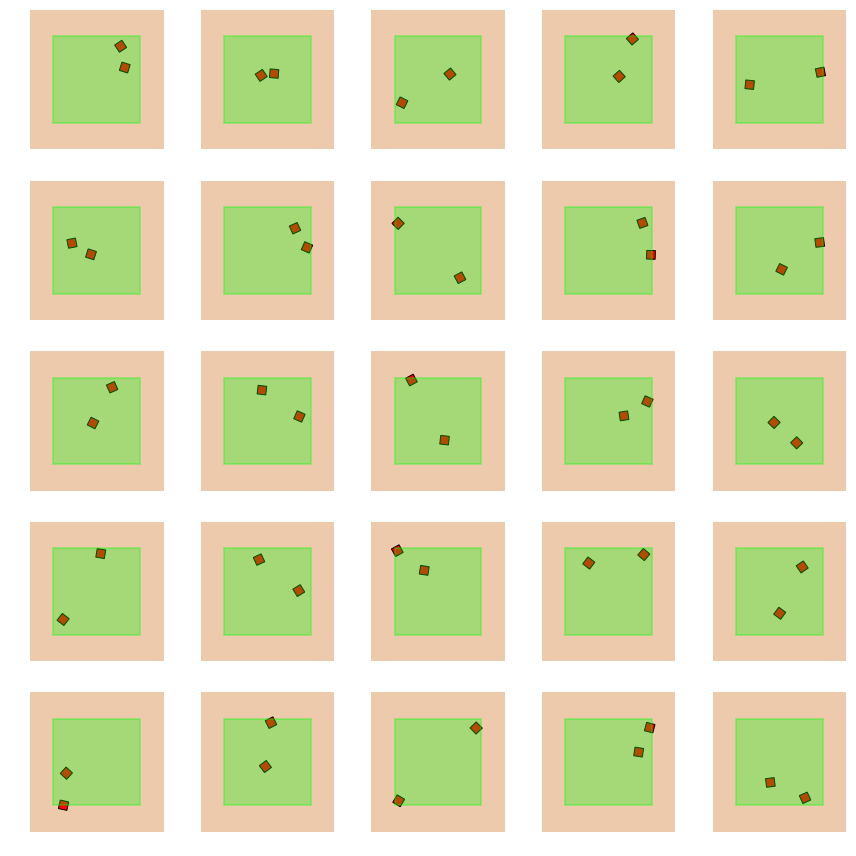

In [8]:
plt.figure().set_size_inches(12, 12)
print "Selection of environments from prior / generative model"
N = 5

for i in range(N):
    for j in range(N):
        plt.subplot(N, N, i*N+j+1)
        draw_environment(environments[i*N+j+1], plt.gca())
        plt.grid(True)
plt.tight_layout()

q0:  tensor([[-0.1000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],
       requires_grad=True) tensor([-27.8826], grad_fn=<AddBackward0>)
qf:  tensor([[0., 0., 0., 0., 0., 0.]], requires_grad=True) tensor([17.9585], grad_fn=<AddBackward0>)
qother:  tensor([[0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]) tensor([5.4585], grad_fn=<AddBackward0>)
tensor([[-0.1000, -0.1000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0959, -0.1000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0918, -0.1000,  0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0918,  0.1000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0959,  0.1000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1000,  0.1000,  0.0000,  0.0000,  0.0000,  0.0000]])
q0_2:  tensor([[1.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]], requires_grad=True) tensor([-27.8826], grad_fn=<AddBackward0>)
qf_2:  tensor([[1., 0., 0., 0., 0., 0.]], requires_grad=True) tensor([8.3019], grad_fn=<AddBackward0>)
qother:  tensor([[0

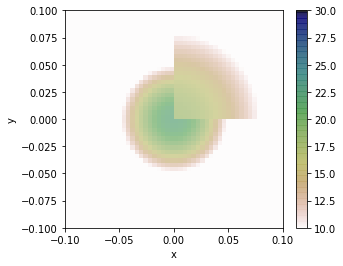

In [9]:
# Test some functionality of the custom distribution type
dummy_env = deepcopy(environments[0])
dummy_env["n_objects"] = 1
one_box_rbt, _ = psa_utils.build_rbt_from_summary(dummy_env)
two_box_rbt, _ = psa_utils.build_rbt_from_summary(environments[0])
ik_constraints = [diff_nlp.object_origins_within_bounds_constraint_constructor_factory(
    np.array([0., 0., 0.5]), np.array([1., 1., 0.5]))]
q0 = torch.tensor([[-0.1 , 0., 0., 0., 0., 0]], requires_grad=True)
distrib = diff_nlp.ProjectToFeasibilityWithIKAsDistribution(
    one_box_rbt, q0, ik_constraints, 0.02, 0.01)
qf = distrib.sample()
qother = torch.Tensor([[0.1 , 0., 0., 0., 0., 0]])
print "q0: ", q0, distrib.log_prob(q0)
print "qf: ", qf, distrib.log_prob(qf)
print "qother: ", qother, distrib.log_prob(qother)

import matplotlib as mpl
# Evaluate at many points over a 2D grid + draw likelihood out
n_points = 50
x_min = -0.1
x_max = 0.1
y_min = -0.1
y_max = 0.1
X, Y = np.meshgrid(np.linspace(x_min, x_max, n_points), np.linspace(y_min, y_max, n_points))
q_probes = np.zeros([n_points*n_points, 6])
q_probes[:, 0] = X.flatten()
q_probes[:, 1] = Y.flatten()
q_probes = torch.tensor(q_probes, dtype=q0.dtype)
print q_probes
z = np.array([distrib.log_prob(q_probes[k, :]).detach().item() for k in range(q_probes.shape[0])])
z = z.reshape(n_points, n_points)
plt.figure()       
h = plt.gca().imshow(np.rot90(z[:, :]),
                     cmap=plt.cm.gist_earth_r,
                     extent=[x_min, x_max, y_min, y_max],
                     alpha=0.6,
                     norm = mpl.colors.Normalize(vmin=10.,vmax=30))
plt.colorbar(h,fraction=0.046, pad=0.04)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])

# Eventually qother should be < qf, but > q0, even though it's the same
# distance from the constraint plane at x>0
if distrib.log_prob(qother).item() <= distrib.log_prob(q0).item():
    raise ValueError("I must not have finished this yet")

q0_2 = torch.tensor([[1.1 , 0., 0., 0., 0., 0]], requires_grad=True)
distrib = diff_nlp.ProjectToFeasibilityWithIKAsDistribution(
    two_box_rbt, q0_2, ik_constraints, 0.1, 0.01, q0_fixed=qf)
qf_2 = distrib.sample()
qother_2 = torch.Tensor([[0.9 , 0., 0., 0., 0., 0]])
print "q0_2: ", q0_2, distrib.log_prob(q0_2)
print "qf_2: ", qf_2, distrib.log_prob(qf_2)
print "qother: ", qother_2, distrib.log_prob(qother_2)
if distrib.log_prob(qother_2).item() <= distrib.log_prob(q0_2).item():
    raise ValueError("I must not have finished this yet")
    

In [82]:
# Ok, now deploy it in an inference context
from collections import namedtuple
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro import poutine
from pyro.infer import config_enumerate
import differentiable_nlp as diff_nlp
import generate_planar_scene_arrangements as psa_utils
import torch.distributions.constraints as constraints

pyro.enable_validation(True)

class DataWrapperForObs:
    # Convenience wrapper on data:
    # If data's batch dimension is length-0,
    # we must be running the model in generative mode,
    # so any slicing returns None.
    # Otherwise, pass through slicing to the real data.
    def __init__(self, data):
        self.data = data
    def __getitem__(self, key):
        if self.data.shape[0] > 0:
            return self.data[key]
        else:
            return None
   
# Cobbling together some RBTs ahead of time for convenience
# 2-obj env
print environments[0]
two_box_rbt, _ = psa_utils.build_rbt_from_summary(environments[0])
# 1-obj env
dummy_env = deepcopy(environments[0])
dummy_env["n_objects"] = 1
one_box_rbt, _ = psa_utils.build_rbt_from_summary(dummy_env)
assert(two_box_rbt.get_num_positions() == 12)
assert(one_box_rbt.get_num_positions() == 6)
rbts = [one_box_rbt, two_box_rbt]
ik_constraint = [diff_nlp.object_at_specified_pose_constraint_constructor_factory(
    0, np.array([0., 0., 0.5, 0., 0., 0.]), np.array([1., 1., 0.5, 0., 0., 2*np.pi]))]
ik_constraint_2 = ik_constraint + [
    diff_nlp.object_at_specified_pose_constraint_constructor_factory(
        1, np.array([0., 0., 0.5, 0., 0., 0.]), np.array([1., 1., 0.5, 0., 0., 2*np.pi]))]
ik_constraints = [ik_constraint, ik_constraint_2]

def expand_partial_pose_to_full_pose(this_pose):
    if this_pose is None:
        return this_pose
    full_poses = torch.zeros(this_pose.shape[0], 6,
                             requires_grad=False,
                             dtype=this_pose.dtype)
    full_poses[:, 0] = this_pose[:, 0]
    full_poses[:, 1] = this_pose[:, 1]
    full_poses[:, 5] = this_pose[:, 2]
    return full_poses

def collapse_full_pose_to_partial_pose(pose):
    if pose is None:
        return None
    partial_pose = torch.zeros(pose.shape[0], 3, requires_grad=False,
                       dtype=pose.dtype)
    partial_pose[:, 0] = pose[:, 0]
    partial_pose[:, 1] = pose[:, 1]
    partial_pose[:, 2] = pose[:, 5]
    return partial_pose

# Sample an exactly 2-object environment
# "data" is either None (run in generative mode),
# or is n_batches x 6 (environment pose vectors)
N_OBJECTS = 2
def model(data = torch.Tensor(0, 12), use_projection=True, subsample_size=None,
          noisy_projection=False, use_amortization=True):
    if data.shape[1] != 12:
        raise ValueError("Expected data to have n_batches x 12 shape.")
    
    # Object placement distribution is shared across objects
    # (maybe switch this to Normal-inverse-Wishart_distribution, if supported?)
    # Normal distributions are specified by standard deviation (scale),
    # but multivariate normals by covariance matrix. :P
    box_mean = pyro.sample('box_mean', dist.Normal(
        torch.Tensor([0.5, 0.5, np.pi]), torch.Tensor([0.5, 0.5, np.pi/2.])).to_event(1))
    box_var = pyro.sample('box_var', dist.LogNormal(
        torch.Tensor([0.0, 0.0, 0.0]), torch.Tensor([2.0, 2.0, 2.0])).to_event(1))
    box_dist = dist.MultivariateNormal(box_mean, torch.diag(box_var))
    
    data_batch_size = max(1, data.shape[0])
    # Who knows why, but pyro's subsampling wasn't being random during SVI.
    # Someone somewhere might be resetting internal RNG state.
    # Here I force RNG from the torch RNG.
    #indices = torch.randperm(data_batch_size)[0:(subsample_size or data_batch_size)]
    #if subsample_size is not None and data.shape[0] > 0:
    #    data_subsample = data[indices, :]
    #else:
    #    data_subsample = data
    with pyro.plate('data', size=data_batch_size) as ind:
        generated_data = torch.zeros(ind.shape[0], 3*N_OBJECTS)
        if data.shape[0] > 0:
            data_obs = DataWrapperForObs(data[ind, :])
        else:
            data_obs = DataWrapperForObs(data[:, :])
        
        
        last_scene_configs = []
        for k in range(N_OBJECTS):
            if use_projection:
                new_pose = pyro.sample("box_%d_pre_pose" % k, box_dist)
                q0_fixed = None
                if len(last_scene_configs) > 0:
                    q0_fixed = torch.cat(last_scene_configs)
                #projection_dist = dist.Normal(new_pose, 0.01*torch.ones(new_pose.shape)).to_event(1)
                #projected_pose = pyro.sample("box_%d_pose" % k, projection_dist,
                #                             obs=collapse_full_pose_to_partial_pose(data_obs[:, (k*6):(k*6+6)]))
                #generated_data[:, (k*3):(k*3+3)] = projected_pose[:, :]
                #last_scene_configs.append(projected_pose)
                #continue
                
                projection_dist = diff_nlp.ProjectToFeasibilityWithIKAsDistribution(
                    rbts[k], expand_partial_pose_to_full_pose(new_pose),
                    ik_constraints[k], 0.05, 0.01, noisy_projection=noisy_projection,
                    q0_fixed=q0_fixed)
                projected_pose = pyro.sample("box_%d_pose" % k, projection_dist, obs=data_obs[:, (k*6):(k*6+6)])
                generated_data[:, (k*3):(k*3+3)] = collapse_full_pose_to_partial_pose(projected_pose)[:, :]
                last_scene_configs.append(projected_pose)
            else:
                projected_pose = pyro.sample("box_%d_pose" % k, box_dist, obs=data_obs[:, [k*6, k*6+1, k*6+5]])
                generated_data[:, (k*3):(k*3+3)] = projected_pose[:, :]
    
    return generated_data

H = 10
inference_module = torch.nn.Sequential(
  torch.nn.Linear(6, H),
  torch.nn.ReLU(),
  torch.nn.Linear(H, 3),
)

def guide(data = torch.Tensor(1, 12), use_projection=True, subsample_size=None,
          noisy_projection=False, use_amortization=True):
    if data.shape[1] != 12:
        raise ValueError("Expected data to have n_batches x 12 shape.")
    if data.shape[0] == 0:
        raise ValueError("Data must have at least one entry.")

    # Intentionally wrong initialization
    est_box_mean = pyro.param('auto_box_mean', torch.tensor([0.25, 0.25, np.pi/2.]))
    est_box_var = pyro.param('auto_box_var', torch.tensor([0.1, 0.1, 0.5]),
                         constraint=constraints.positive)
    box_mean = pyro.sample("box_mean", dist.Delta(est_box_mean).to_event(1))
    box_var = pyro.sample("box_var", dist.Delta(est_box_var).to_event(1))
    
    if use_projection:
        if use_amortization:
            pyro.module("inference_module", inference_module)
        else:
            box_pre_poses = []
            for k in range(N_OBJECTS):
                box_pre_poses.append(pyro.param('auto_box_%d_pre_poses' % k,
                                     torch.randn(data.shape[0], 3)*0.5 + 0.5))

    with pyro.plate('data', size=data.shape[0], subsample_size=subsample_size) as ind:
        for k in range(N_OBJECTS):
            if use_projection:
                if use_amortization:
                    #print "Input: ", data[ind, (k*6):(k*6+6)]
                    #print "Output base ", collapse_full_pose_to_partial_pose(
                    #            data[ind, (k*6):(k*6+6)])
                    #print "Output residual: ", inference_module(data[ind, (k*6):(k*6+6)])
                    predicted_pre_pose_base = collapse_full_pose_to_partial_pose(
                        data[ind, (k*6):(k*6+6)])
                    predicted_pre_pose_residual = inference_module(data[ind, (k*6):(k*6+6)])
                    new_pose = pyro.sample(
                        "box_%d_pre_pose" % k,
                        dist.Delta(predicted_pre_pose_base + predicted_pre_pose_residual).to_event(1))
                else:
                    new_pose = pyro.sample(
                        "box_%d_pre_pose" % k,
                        dist.Delta(box_pre_poses[k][ind, :]).to_event(1))

for k in range(10):
    pyro.clear_param_store()
    model()
    pyro.clear_param_store()
    model(torch.zeros(10, 12), use_projection=True, subsample_size=5, use_amortization=True)
    pyro.clear_param_store()
    guide(torch.zeros(10, 12), use_projection=True, subsample_size=5)

{'obj_0000': {'pose': [0.8509978117586199, 0.489187803635579, 1.6982042672090187], 'class': 'small_box'}, 'obj_0001': {'pose': [0.6158417183505649, 0.8990436884493441, 2.966257382400049], 'class': 'small_box'}, 'n_objects': 2}


In [83]:
def vectorize_environments(envs):
    # Vectorization into a 
    # poses (order x y 0 0 0 theta) per object
    n_environments = len(envs)
    poses = torch.Tensor(n_environments, 2*6)
    poses[:, :] = 0.
    for i, env in enumerate(envs):
        for k in range(2):
            obj = env["obj_%04d" % k]
            poses[i, (k*6):(k*6+6)][[0, 1, 5]] = torch.Tensor(obj["pose"])
    return poses
    
def devectorize_environments(data):
    envs = []
    for i in range(data.shape[0]):
        env = {}
        n_objects = 0
        for k in range(2):
            obj = {
                "pose": data[i, (k*3):(k*3+3)].cpu().detach().numpy(),
                "class": "small_box"
            }
            env["obj_%04d" % k] = obj
        env["n_objects"] = 2
        envs.append(env)
    return envs

# Make sure we can run model + condition on this dataset
model(vectorize_environments(environments), subsample_size=20, use_projection=True)

tensor([[0.8510, 0.4892, 1.6982, 0.6158, 0.8990, 2.9663],
        [0.7750, 0.8844, 0.5871, 0.8227, 0.6387, 5.9812],
        [0.4278, 0.5484, 3.7347, 0.5774, 0.5690, 3.0618],
        ...,
        [0.4015, 0.0536, 1.6626, 0.1406, 0.2834, 4.5140],
        [0.6965, 0.2218, 5.1179, 0.9329, 0.9890, 4.9938],
        [0.4356, 0.3911, 4.6547, 0.8713, 0.9727, 4.7796]])

In [84]:
# Some statistics over what we expect of environment mean + var
data = vectorize_environments(environments).detach().numpy()
print "Mean postures: ", np.mean(data, axis=0)
print "std postures: ", np.std(data, axis=0)
print "log-std postures: ", np.log(np.std(data, axis=0))
print "var postures: ", np.square(np.std(data, axis=0))

Mean postures:  [0.50985354 0.50948626 0.         0.         0.         3.2155168
 0.4947123  0.49772808 0.         0.         0.         3.161191  ]
std postures:  [0.2870375  0.28578308 0.         0.         0.         1.8388928
 0.29076204 0.29229698 0.         0.         0.         1.8325927 ]
log-std postures:  [-1.2481425  -1.2525222         -inf        -inf        -inf  0.60916364
 -1.2352501  -1.229985          -inf        -inf        -inf  0.6057317 ]
var postures:  [0.08239052 0.08167197 0.         0.         0.         3.3815267
 0.08454257 0.08543752 0.         0.         0.         3.358396  ]


/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


Selection of environments from prior / generative model


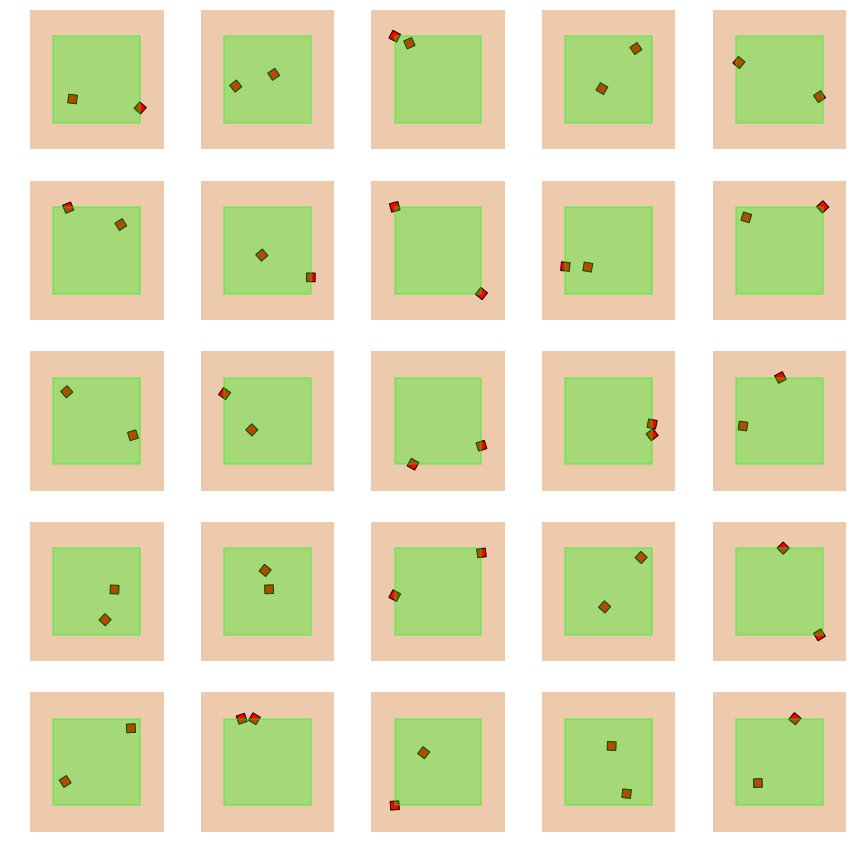

In [85]:
plt.figure().set_size_inches(12, 12)
print "Selection of environments from prior / generative model"
N = 5

for i in range(N):
    for j in range(N):
        plt.subplot(N, N, i*N+j+1)
        draw_environment(devectorize_environments(
            poutine.condition(model, data={"box_var": torch.Tensor([0.25, 0.25, 3.1415]),
                                           "box_mean": torch.Tensor([0.5, 0.5, 3.1415])})())[0], plt.gca())
        plt.grid(True)
plt.tight_layout()

Notes on SVI performance:

Using noisy projection didn't seem to have an important impact on SVI.

In [89]:
# Rig for SVI.
from collections import defaultdict
from torch.distributions import constraints
from pyro.infer import Trace_ELBO, SVI
from pyro.contrib.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal
import pyro.optim
import torch.optim

pyro.enable_validation(True)

interesting_params = ["auto_box_mean", "auto_box_var"] #, "box_0_pre_pose"]
def select_interesting(guide):
    #all_params = guide.median()
    return dict((p, pyro.param(p).cpu().detach().numpy()) for p in interesting_params)

pyro.clear_param_store()
#global_guide = AutoDelta(
#    poutine.block(model, hide=["obs"]))
#    #poutine.block(model, expose=interesting_params))
optimizer = torch.optim.Adam
def per_param_args(module_name, param_name):
    if module_name == 'inference_module':
        return {"lr": 0.01, 'betas': [0.9, 0.99]}
    else:
        return {'lr': 0.1, 'betas': [0.9, 0.99]}
scheduler = pyro.optim.StepLR(
    {"optimizer": optimizer,
     'optim_args': per_param_args,
     'gamma': 0.25, 'step_size': 100})
elbo = Trace_ELBO(max_plate_nesting=1, num_particles=4)
svi = SVI(model, guide, scheduler, loss=elbo)
losses = []
data = vectorize_environments(environments)
use_amortization=True

snapshots = {}
start_time = time.time()
avg_duration = None
num_iters = 501
for i in range(num_iters):
    loss = svi.step(data, subsample_size=25, use_projection=True, use_amortization=use_amortization)
    losses.append(loss)
    for p in interesting_params:
        if p not in snapshots.keys():
            snapshots[p] = []
        snapshots[p].append(pyro.param(p).cpu().detach().numpy().copy())
        
    elapsed = time.time() - start_time
    if avg_duration is None:
        avg_duration = elapsed
    else:
        avg_duration = avg_duration*0.9 + elapsed*0.1
    start_time = time.time()
    if (i % 10 == 0):
        print "Loss %f, Per iter: %f, To go: %f" % (loss, elapsed, (num_iters - i)*elapsed)
    if (i % 50 == 0):
        print select_interesting(guide)
print "Done"


Loss -9714.626251, Per iter: 0.481133, To go: 241.047625
{'auto_box_mean': array([0.35000002, 0.35      , 1.6707964 ], dtype=float32), 'auto_box_var': array([0.11051708, 0.11051708, 0.5525855 ], dtype=float32)}
Loss -18325.843865, Per iter: 0.569378, To go: 279.564666
Loss -19620.583332, Per iter: 0.567718, To go: 273.072257
Loss -20048.181512, Per iter: 0.811031, To go: 381.995650
Loss -20069.110371, Per iter: 0.524254, To go: 241.681023
Loss -20160.010500, Per iter: 0.604024, To go: 272.414901
{'auto_box_mean': array([0.5011021, 0.5049079, 3.4115732], dtype=float32), 'auto_box_var': array([0.08134762, 0.07605388, 3.855856  ], dtype=float32)}
Loss -20178.088893, Per iter: 0.575520, To go: 253.804337
Loss -20196.053049, Per iter: 0.559889, To go: 241.312193
Loss -20248.002573, Per iter: 0.508863, To go: 214.231311
Loss -20190.024906, Per iter: 0.502166, To go: 206.390239
Loss -20210.138229, Per iter: 0.487759, To go: 195.591404
{'auto_box_mean': array([0.50624925, 0.5268016 , 3.188528 

In [76]:
num_additional_iters = 501
for i in range(num_additional_iters):
    loss = svi.step(data, subsample_size=50, use_projection=True, use_amortization=use_amortization)
    losses.append(loss)
    for p in interesting_params:
        if p not in snapshots.keys():
            snapshots[p] = []
        snapshots[p].append(pyro.param(p).cpu().detach().numpy().copy())
        
    elapsed = time.time() - start_time
    if avg_duration is None:
        avg_duration = elapsed
    else:
        avg_duration = avg_duration*0.9 + elapsed*0.1
    start_time = time.time()
    if (i % 10 == 0):
        print "Loss %f, Per iter: %f, To go: %f" % (loss, elapsed, (num_additional_iters - i)*elapsed)
    if (i % 50 == 0):
        print select_interesting(guide)
print "Done"


Loss -12025.890919, Per iter: 50.847440, To go: 25474.567442
{'auto_box_mean': array([0.4900025, 0.5086733, 3.197168 ], dtype=float32), 'auto_box_var': array([0.08228467, 0.07984874, 3.3728604 ], dtype=float32)}
Loss -14726.611569, Per iter: 0.075279, To go: 36.961988
Loss -16580.085116, Per iter: 0.075397, To go: 36.265964
Loss -17219.484847, Per iter: 0.077654, To go: 36.574980
Loss -17294.011604, Per iter: 0.074749, To go: 34.459286
Loss -17326.012648, Per iter: 0.074778, To go: 33.724914
{'auto_box_mean': array([0.5048035, 0.4897395, 3.2057605], dtype=float32), 'auto_box_var': array([0.0821969 , 0.08308416, 3.4176037 ], dtype=float32)}
Loss -17303.402361, Per iter: 0.076153, To go: 33.583491
Loss -17454.299208, Per iter: 0.075734, To go: 32.641414
Loss -17211.402939, Per iter: 0.075486, To go: 31.779583
Loss -17281.125851, Per iter: 0.076290, To go: 31.355146
Loss -17402.601404, Per iter: 0.074743, To go: 29.971956
{'auto_box_mean': array([0.49896413, 0.5037807 , 3.1940613 ], dtype

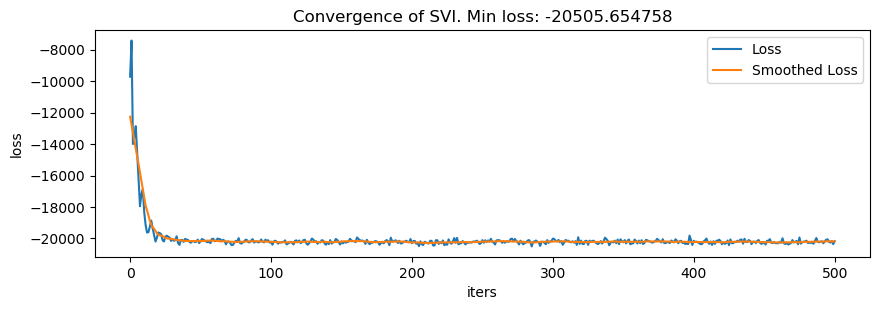

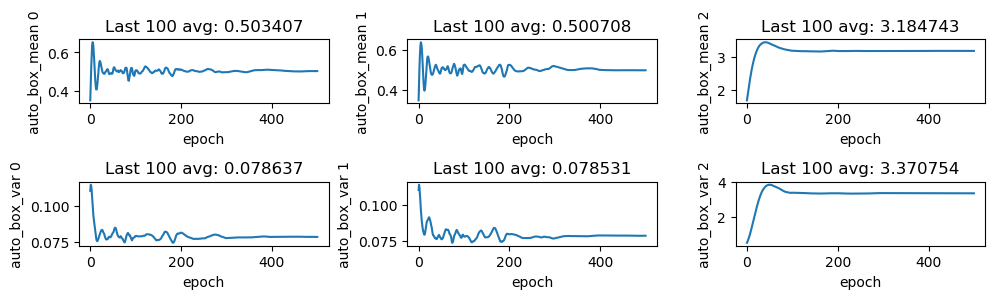

In [108]:
import scipy as sp
import scipy.ndimage
start_epoch = 0
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
range_fixed_losses = losses[start_epoch:] - np.min(losses[start_epoch:])*0
plt.plot(range_fixed_losses, label="Loss")
plt.xlabel('iters')
plt.ylabel('loss')
#plt.yscale('log')
plt.title('Convergence of SVI. Min loss: %f' % np.min(losses[start_epoch:]));

def smooth(y, box_pts):
    # Kind of shitty gaussian kernel
    ax = np.arange(-box_pts//2 + 1., box_pts // 2 + 1.)
    kernel = np.exp(-ax**2 / (box_pts**2))
    kernel /= np.sum(kernel)
    y_smooth = sp.ndimage.convolve(y, kernel, mode='nearest')
    return y_smooth
plt.plot(smooth(range_fixed_losses, 20)[start_epoch:], label="Smoothed Loss")
plt.legend()

plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
keys = ["auto_box_mean", "auto_box_var"]
fit_vals = {}
n_plots = len(keys)
for i, key in enumerate(keys):
    data_across_epochs = np.vstack(snapshots[key])
    for k in range(3):
        plt.subplot(n_plots, 3, i*3+k+1)
        plt.plot(np.arange(start_epoch, data_across_epochs.shape[0]), data_across_epochs[start_epoch:, k])
        plt.xlabel('epoch')
        plt.ylabel(key + " %d" % k)
        plt.title("Last 100 avg: %f" % data_across_epochs[-100:, k].mean())
    fit_vals[key] = data_across_epochs[-100:].mean(axis=0)
plt.tight_layout()

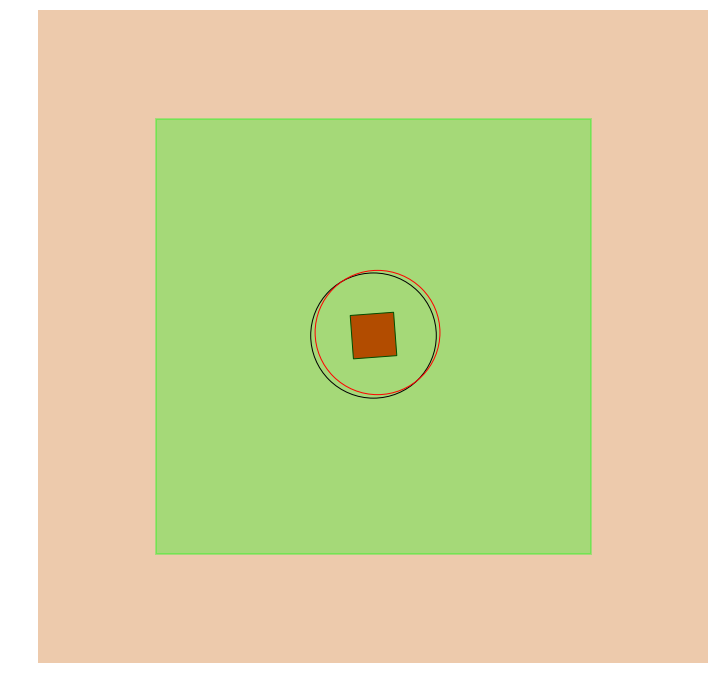

In [78]:
from matplotlib.patches import Ellipse
plt.figure().set_size_inches(12, 12)


data = vectorize_environments(environments).detach().numpy()
real_vals = {}
real_vals["box_mean"] = np.mean(data, axis=0)
real_vals["box_var"] = np.square(np.std(data, axis=0))

env = {"n_objects": 1}
for k in range(1):
    object_name = "box"
    env["obj_%04d" % k] = {"class": "small_box", "pose": fit_vals["auto_" + object_name + "_mean"]}
# One object of each class, right at its mean
draw_environment(env, plt.gca())
# And draw ellipses
object_name = "box"
var = fit_vals["auto_" + object_name + "_var"]
mean = fit_vals["auto_" + object_name + "_mean"]
lambda_ = np.sqrt(var)
ell = Ellipse(xy=mean[0:2],
              width=lambda_[0], height=lambda_[1],
              color='black')
ell.set_facecolor('none')
plt.gca().add_artist(ell)

var = real_vals[object_name + "_var"]
mean = real_vals[object_name + "_mean"]
lambda_ = np.sqrt(var)
ell = Ellipse(xy=mean[0:2],
              width=lambda_[0], height=lambda_[1],
              color='red')
ell.set_facecolor('none')
plt.gca().add_artist(ell)
plt.show()

Selection of example environments, with our understanding of the pre-projection locations labeled


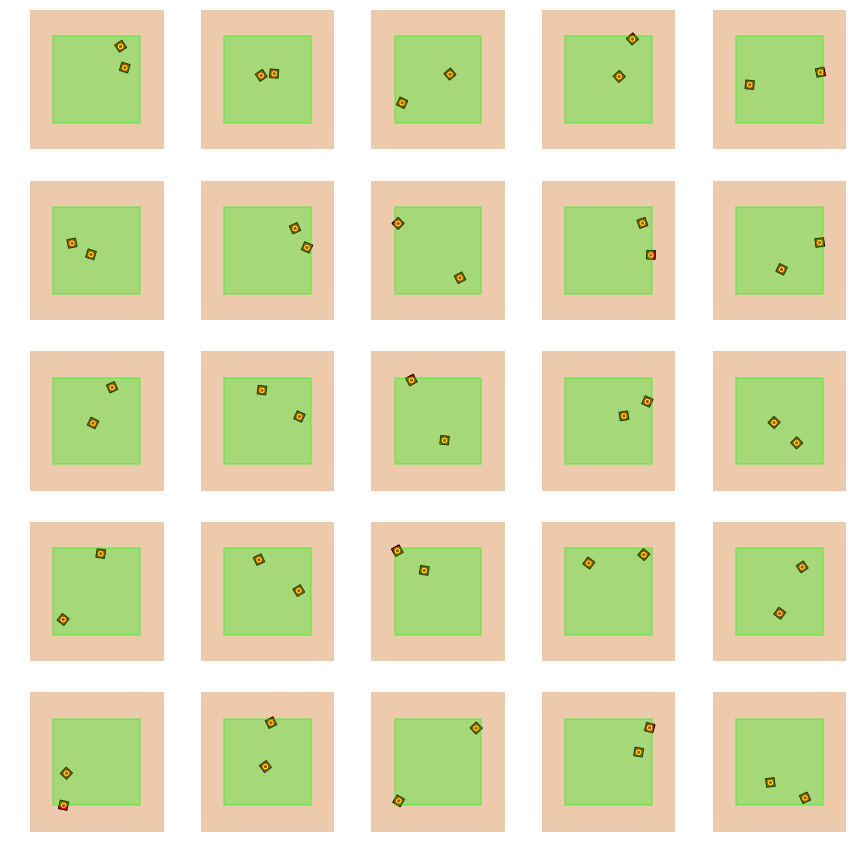

In [80]:
plt.figure().set_size_inches(12, 12)
print "Selection of example environments, with our understanding of the pre-projection locations labeled"
N = 5
data = vectorize_environments(environments)

if not use_amortization:
    pre_poses = [pyro.param("auto_box_%d_pre_poses" % k).cpu().detach().numpy() for k in range(2)]
for i in range(N):
    for j in range(N):
        env_i = i*N+j+1
        plt.subplot(N, N, env_i)
        draw_environment(environments[env_i], plt.gca())
        for k in range(2):
            if use_amortization:
                mean = inference_module(data[env_i, (6*k):(6*k+6)])
            else:
                mean = pre_poses[k][env_i, 0:2]
            ell = Ellipse(xy=mean[0:2],
                          width=0.05, height=0.05,
                          color='yellow')
            ell.set_facecolor('none')
            plt.gca().add_artist(ell)

plt.tight_layout()

Selection of environments from prior / generative model


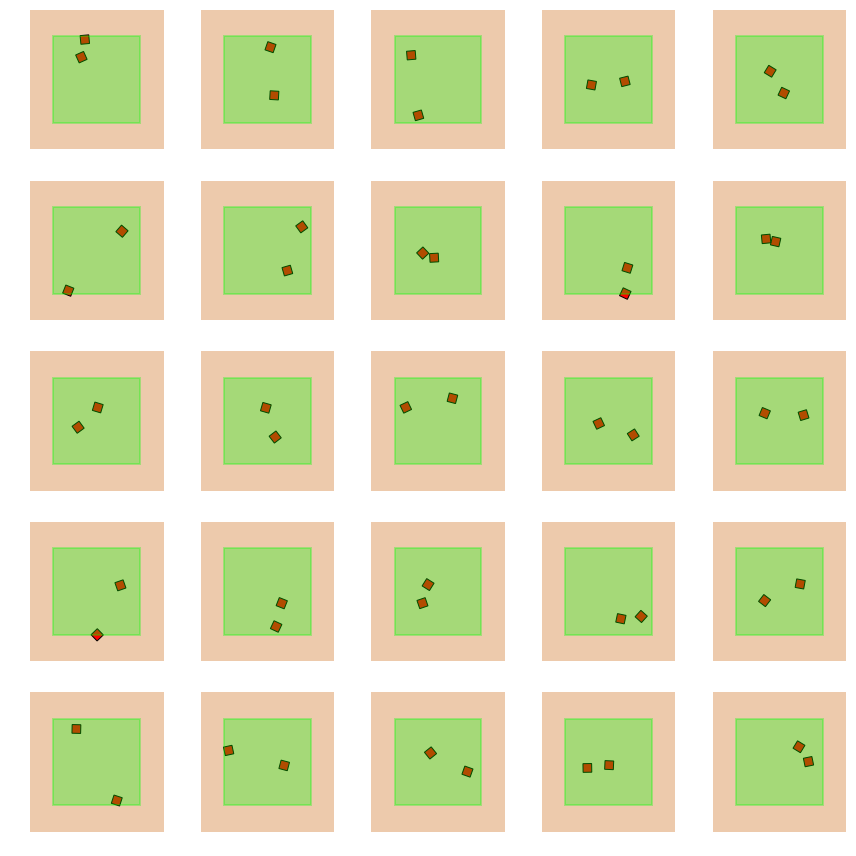

In [19]:
plt.figure().set_size_inches(12, 12)
print "Selection of environments from prior / generative model"
N = 5

for i in range(N):
    for j in range(N):
        plt.subplot(N, N, i*N+j+1)
        sample = poutine.condition(model, data={
            "box_mean": pyro.param("auto_box_mean"),
            "box_var": pyro.param("auto_box_var")})()
        draw_environment(devectorize_environments(sample)[0], plt.gca())
        plt.grid(True)
plt.tight_layout()

In [109]:
# MCMC as an alternative inference mechanism

from pyro.infer.mcmc import HMC, MCMC, NUTS
from pyro.infer import EmpiricalMarginal

hmc_kernel = NUTS(model)
# Struggles a *lot* with larger sample sizes. 20-50 seems like reasonable range.
# Noisy projection doesn't seem critical...
# From a few runs, it looks like the empirical mean estimates are better
# when I'm using more samples and smaller subsample size. But I suspect
# that's not really very true, as it generally varies significantly run-to-run
# for ~500 sample territory.
# But when the mean estimate is bad, the variance estimate is really high --
# so the empirical distribution over sample locations still looks great. Beyond
# the power of having projection in the loop...
# I'll need to try this on a "harder" distribution...
# Update: looks like I broke this with recent changes, with include
# switching to a multivariate normal prior for the box center prior., and switching
# on the increased logprob penalty for samples out in infeasible space... oops...
# I'll stick with SVI...
mcmc_run = MCMC(hmc_kernel, num_samples=900, warmup_steps=100).run(data, subsample_size=10, use_projection=True, noisy_projection=False
                                                                )

SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdXYXJtdXAnLCBtYXg9MTAwMCwgc3R5bGU9UHJvZ3Jlc3NTdHlsZShkZXNjcmlwdGlvbl93aWR0aD11J2nigKY=


KeyboardInterrupt: 

In [ ]:
# do some analysis of that when it comes out
posterior_box_mean = EmpiricalMarginal(mcmc_run, 'box_mean')
print "Box mean, empirical: ", posterior_box_mean.mean, " +/- ", posterior_box_mean.variance
posterior_box_var = EmpiricalMarginal(mcmc_run, 'box_var')
print "Box var, empirical: ", posterior_box_var.mean, " +/- ", posterior_box_var.variance
print "I don't trust those variance estimates..."

def plot_empirical_marginal(ax, empirical_marginal, subind_x, subind_y):
    datapoints = empirical_marginal._samples.detach().numpy()
    plt.scatter(datapoints[:, :, subind_x].flatten(), datapoints[:, :, subind_y].flatten())
    plt.show()

plt.figure()
plt.subplot(2, 1, 1)
plot_empirical_marginal(plt.gca(), EmpiricalMarginal(mcmc_run, 'scene_0_pose'), 0, 1)
plt.title("Scene 0 pose samples")
plt.subplot(2, 1, 2)
plt.title("Scene 1 pose samples")
plot_empirical_marginal(plt.gca(), EmpiricalMarginal(mcmc_run, 'scene_1_pose'), 0, 1)
plt.tight_layout();